# Waxman

In [16]:
import scipy

import seaborn as sns

In [17]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
import math

class Waxman_square:
    def __init__(self, n, R, gamma = 0.2, beta = 1.0):
        # Alfa and beta are constants on the interval from 0 to 1.
        # Constant n is the number of nodes, R is the length of the side of the square (in kilometers)
        # gamma is the fibers loss rate?. Beta is usually 1 and state-of-the-art gamma is 0.2 dB per km
        # for a state of the art capel alfa*sqrt(2)*R = 226 (km).
        self.beta = beta
        self.n = n
        self.R = R
        self.gamma = gamma
        self.alfa = 226/(np.sqrt(2)*R)

        # alustetaan tarvittavat matriisit nolla matriiseiksi, joissa n*n alkiota
        self.distance_matrix = [[0 for _ in range(n)] for _ in range(n)]
        self.propability_matrix = [[0 for _ in range(n)] for _ in range(n)]
        self.adjacency_matrix_weighted_cap = [[0 for _ in range(n)] for _ in range(n)]
        self.adjacency_matrix = [[0 for _ in range(n)] for _ in range(n)]
        self.capacity_matrix = [[0 for _ in range(n)] for _ in range(n)]
        self.min_cut_matrix = [[0 for _ in range(n)] for _ in range(n)]
        self.min_weight_degree = [[0 for _ in range(n)] for _ in range(n)]

        # create a Networkx graph from the nodes:
        self.G = nx.Graph()
        self.nodes = []
        i=0
        # next we create # n nodes with random coordinates on the square
        while i < self.n :
            noodi = (random.uniform(0, self.R), random.uniform(0, self.R))
            self.nodes.append(noodi)
            self.G.add_node(i, pos = noodi)
            i += 1


    def getDistance(self, node1: tuple, node2: tuple) -> float:
        # returns the distance between two nodes of the graph
        x = abs(node1[0] - node2[0])
        y = abs(node1[1] - node2[1])
        length = math.sqrt(x**2 + y**2)
        return length
    
    def distanceMatrix(self) -> list:
        #returns the distance matrix of the network
        for i in range(self.n):
            for j in range(self.n):
                self.distance_matrix[i][j] = self.getDistance(self.nodes[i], self.nodes[j])
        return self.distance_matrix

    def propabilityMatrix(self) -> list:
        # returns propability matrix from distance matrix according to p = e^(-D(x,y)/alfa*L)
        for i in range(self.n):
            for j in range(self.n):
                if i != j:
                    self.propability_matrix[i][j] = math.exp(- self.distance_matrix[i][j]/(self.alfa*self.R*math.sqrt(2)))
                else:
                    self.propability_matrix[i][j] = 0
        return self.propability_matrix
    
    def adjacencyMatrix(self) -> list:
        # determines links between nodes from the propabilities.
        # should the element be zero ore none when there is no link?
        for i in range(self.n):
            for j in range(i, self.n):
                if i != j:
                    k = random.uniform(0, 1.0)
                    if self.propability_matrix[i][j] >= k:
                        self.adjacency_matrix[i][j] = self.adjacency_matrix[j][i] = 1

                        distance = self.distance_matrix[i][j]
                        self.adjacency_matrix_weighted_cap[i][j] = self.adjacency_matrix_weighted_cap[j][i] = - math.log2(1 - 10**(-self.gamma*distance*0.1))

                        self.G.add_edge(i, j, weight=self.propability_matrix[i][j], capacity= self.adjacency_matrix_weighted_cap[i][j])
                    else:
                        self.adjacency_matrix[i][j] = self.adjacency_matrix[j][i] = None
                        self.adjacency_matrix_weighted_cap[i][j] = self.adjacency_matrix_weighted_cap[j][i] = None
                if i == j:
                    self.adjacency_matrix[i][j] = None
                    self.adjacency_matrix_weighted_cap[i][j] = None

        return self.adjacency_matrix
    
    def degree(self) -> list:
        # sum over rows gives degrees of nodes
        self.degrees = [sum(element for element in row if element is not None) for row in self.adjacency_matrix]
        return self.degrees
    
    def degree_weighted(self) -> list:
        # for convenience lets sum over rows so we get degrees of nodes weighted with capacity
        self.degree_weight = [sum(element for element in row if element is not None) for row in self.adjacency_matrix_weighted_cap]
        return self.degree_weight


    def capacityMatrix(self) -> list:
        #creates a capacity matrix from the distance_matrix according to maximum capacity of the link
        # C = log_2(1 - eta) = log_2(1-10^(-gamma*D/10))
        # oletuksena kaikki arvot matriisissa nollia, joten muutetaan arvoja vain kun noodien välillä linkki
        for i in range(self.n):
            for j in range(self.n):
                if self.adjacency_matrix[i][j] == 1:
                    distance = self.distance_matrix[i][j]
                    self.capacity_matrix[i][j] = - math.log2(1 - 10**(-self.gamma*distance*0.1))

        return self.capacity_matrix 
    
    def minimum_cuts(self) -> list:
        # palauttaa matriisin, jonka alkiot ovat minimileikkauksia noodien välillä
        for i in range(self.n):
            for j in range(i+1, self.n):
                if i != j:
                    self.min_cut_matrix[i][j] = self.min_cut_matrix[j][i] = nx.minimum_cut_value(self.G, i, j) 
        return self.min_cut_matrix
    
    def min_degree_weight(self) -> list:
        #palauttaa matriisin, jonka alkioina min(d_C(i),d_C(j)) missä d_C on noodin kapasiteetilla painotettu aste
        for i in range(self.n):
            for j in range(i+1, self.n):
                if i != j:
                    self.min_weight_degree[i][j] = self.min_weight_degree[j][i] = min(self.degree_weight[i],self.degree_weight[j])
        return self.min_weight_degree
    


In [18]:
Ö=25
testi = Waxman_square(n=Ö, R= 200)


In [19]:
distance_matrix = testi.distanceMatrix()

In [20]:
print(distance_matrix)

[[0.0, 174.53643918402915, 136.48877600696377, 59.47356620477359, 140.57907161871395, 28.37426566874339, 87.64744046434821, 117.11527201472056, 19.852159136199322, 20.82891875928181, 28.46078202771228, 97.64263101251989, 202.9259402272579, 153.5975148858448, 125.10743694631684, 144.73787474905, 98.66866957615838, 38.14094652890026, 81.67617708048533, 97.29258239431049, 27.44024179627122, 134.7109125123456, 106.71513901379129, 73.36100454947987, 94.46437184576381], [174.53643918402915, 0.0, 39.47125836974438, 147.50581110714717, 49.533787325907696, 202.11619707459684, 166.7437911032948, 92.50248767067946, 194.20623278917768, 167.9081023824001, 181.05849992426187, 133.36143673118073, 94.32221498247624, 164.89188065140146, 54.489388861370614, 64.05153468475575, 137.15345590312836, 192.42447433003997, 176.22420785162342, 77.47221904250198, 188.85555909479078, 66.05098065053419, 76.89635984137419, 102.93007211841591, 145.05387085163892], [136.48877600696377, 39.47125836974438, 0.0, 108.2734

In [21]:
probability_matrix = testi.propabilityMatrix()

In [22]:
print(probability_matrix)

[[0, 0.46195623162396465, 0.5466575973412982, 0.7686209279285476, 0.5368528253167587, 0.8820117967261905, 0.6785341067989961, 0.5955861881756336, 0.9159061168275435, 0.9119561626416609, 0.8816742133410312, 0.6491788386732655, 0.4074233792396787, 0.5068019303624931, 0.5748922023978424, 0.5270641167859026, 0.6462382510470007, 0.8447071750143199, 0.6967009498226244, 0.6501851228953142, 0.8856645612551847, 0.5509749219497031, 0.6236344618405778, 0.7228119302329146, 0.6583727977119133], [0.46195623162396465, 0, 0.8397495505515618, 0.5206482651377946, 0.8031803057212589, 0.40888576869956966, 0.47816262465294346, 0.6641129471839526, 0.423450093795508, 0.47570555159983297, 0.44881531322705004, 0.5542747077369823, 0.6587870528150672, 0.4820969271972828, 0.7857603034245548, 0.7532079929349879, 0.5450522056699406, 0.4268017210447938, 0.45851919101026345, 0.7097819779653995, 0.4335951272590201, 0.7465736724901151, 0.7115928437319333, 0.6341670984900899, 0.5263276839334761], [0.5466575973412982, 0.

# linkkien arpominen/muodostaminen todnäk mukaan:

linkkien todennäköisyydet p= beta*exp(-d/alfa*L):

In [23]:
adj_matrix = testi.adjacencyMatrix()

In [24]:
print(adj_matrix)

[[None, None, None, 1, 1, 1, 1, None, 1, None, 1, None, None, None, None, 1, 1, 1, None, None, 1, 1, 1, None, 1], [None, None, 1, None, None, 1, 1, None, None, None, 1, 1, None, 1, 1, 1, None, None, 1, 1, 1, None, 1, 1, None], [None, 1, None, 1, 1, None, 1, None, None, 1, 1, None, None, 1, 1, None, None, None, 1, 1, 1, 1, None, 1, None], [1, None, 1, None, 1, None, 1, 1, 1, 1, 1, 1, None, 1, 1, None, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, None, 1, 1, None, 1, None, 1, 1, None, 1, None, None, 1, None, 1, 1, 1, None, 1, 1, 1, 1, None, 1], [1, 1, None, None, 1, None, None, None, 1, 1, 1, 1, None, None, 1, None, 1, 1, None, None, 1, None, 1, None, 1], [1, 1, 1, 1, None, None, None, 1, 1, 1, 1, 1, 1, 1, 1, None, None, 1, 1, None, 1, 1, None, 1, 1], [None, None, None, 1, 1, None, 1, None, None, None, 1, 1, None, None, 1, 1, 1, 1, None, 1, 1, 1, 1, 1, 1], [1, None, None, 1, 1, 1, 1, None, None, 1, 1, 1, 1, None, 1, 1, None, 1, None, None, None, 1, None, 1, 1], [None, None, 1, 1, None, 1, 1, None, 1,

# kapasiteetit linkeille:

In [25]:
capacit_matrix = testi.capacityMatrix()

In [26]:
print(capacit_matrix)

[[0, 0, 0, 0.09641263452844884, 0.0022280678964063383, 0.4554482920930287, 0.025709262153224048, 0, 0.738955145031393, 0, 0.45332039047675315, 0, 0, 0, 0, 0.001839474971810154, 0.015421272544698099, 0.27344036500605234, 0, 0, 0.4791804566813721, 0.002920086600280344, 0.010628464342120161, 0, 0.018737182059443868], [0, 0, 0.25565944399673945, 0, 0, 0.00013087909900628402, 0.0006674199278982046, 0, 0, 0, 0.0003451886405208156, 0.003107516535232919, 0, 0.0007268525586071727, 0.12237004143150346, 0.07758343163643198, 0, 0, 0.0004312760029478233, 0.04129821981518593, 0.00024104583822042195, 0, 0.04242454810454167, 0.01266127420846504, 0], [0, 0.25565944399673945, 0, 0.009889940512117529, 0.6186793997890623, 0, 0.0037524031651597744, 0, 0, 0.0038313401221706533, 0.002110586345014675, 0, 0, 0.0026172827501786938, 0.38991810961753404, 0, 0, 0, 0.002496082511220891, 0.23294424580947343, 0.0012768285768975192, 0.282181341196765, 0, 0.0781220262844329, 0], [0.09641263452844884, 0, 0.0098899405121

In [27]:
print(testi.nodes)

[(29.32086304870665, 29.744739503376614), (81.57745559277483, 196.27466816103126), (78.94968585757371, 156.8909778373722), (85.65064820240484, 48.82510589534588), (100.96984516191694, 150.69472395695306), (27.94634121023085, 1.4037860621816112), (116.8955907130053, 33.31417846144684), (114.70266233736301, 109.90667117492248), (26.13979340774273, 10.149101766667968), (50.08816166088739, 31.345728270756833), (54.86646728486557, 17.197300807033457), (119.03678866292331, 68.28220286348181), (172.99575538425452, 173.05022624231967), (179.19040294430246, 63.37980439984629), (47.8587727278037, 153.47111779032997), (118.37152589526265, 143.8457116002904), (121.45790771570304, 65.04730819123606), (58.543234167977396, 5.233827070583752), (110.67231922270801, 22.468855993291136), (54.186960823355925, 123.80601618201456), (2.319769271009986, 24.855178720866554), (110.7849680162253, 137.0323415445721), (33.34733156758758, 136.38389012827264), (62.643361464617556, 95.10105586094394), (119.9499665184

# asteet ja painotetut asteet

In [28]:
degrees = testi.degree()

In [29]:
weighted_degrees = testi.degree_weighted()

In [30]:
min_cuts = testi.minimum_cuts()

In [31]:
min_degree_weighted = testi.min_degree_weight()

# astejakauma:

def plot_degree_dist(G):
    degrees = [G.degree(n) for n in G.nodes()]
    plt.hist(degrees, ec='black')
    plt.ylabel("Noodien #, joilla tietty aste")
    plt.xlabel("Aste")
    plt.show()

plot_degree_dist(testi.G)

vaihtoehtoinen tapa

In [32]:
from collections import Counter

#degrees = np.sum(adj_matrix, axis=1)

# Count occurrences of each degree
degree_counts = Counter(degrees)

# Total number of nodes
total_nodes = len(degrees)

# Calculate probabilities
degree_values = list(degree_counts.keys())
probabilities = [count / total_nodes for count in degree_counts.values()]


# Plot the degree distribution with probabilities

plt.bar(degree_values, probabilities, width=0.8, color='blue', edgecolor='black', alpha=0.7)
plt.rcParams['axes.facecolor'] = 'white'
plt.legend()
plt.xlabel("Aste")
plt.ylabel("P(k)")
plt.title("Astejakauma")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(degrees, bins=10, kde=True, color='green')
plt.title("Astejakauma")
plt.xlabel("Aste")
plt.ylabel("Lkm")
plt.show()

# painotettu astejakauma:

In [33]:
adj_painotettu = testi.adjacency_matrix_weighted_cap

In [34]:
print(adj_painotettu)

[[None, None, None, 0.09641263452844884, 0.0022280678964063383, 0.4554482920930287, 0.025709262153224048, None, 0.738955145031393, None, 0.45332039047675315, None, None, None, None, 0.001839474971810154, 0.015421272544698099, 0.27344036500605234, None, None, 0.4791804566813721, 0.002920086600280344, 0.010628464342120161, None, 0.018737182059443868], [None, None, 0.25565944399673945, None, None, 0.00013087909900628402, 0.0006674199278982046, None, None, None, 0.0003451886405208156, 0.003107516535232919, None, 0.0007268525586071727, 0.12237004143150346, 0.07758343163643198, None, None, 0.0004312760029478233, 0.04129821981518593, 0.00024104583822042195, None, 0.04242454810454167, 0.01266127420846504, None], [None, 0.25565944399673945, None, 0.009889940512117529, 0.6186793997890623, None, 0.0037524031651597744, None, None, 0.0038313401221706533, 0.002110586345014675, None, None, 0.0026172827501786938, 0.38991810961753404, None, None, None, 0.002496082511220891, 0.23294424580947343, 0.00127

plt.hist(adj_painotettu, color='pink', ec= 'black')
plt.ylabel("Noodien #, joilla tietty aste")
plt.xlabel("Painotettu aste")
plt.show()

vaihtoehtoinen esitys

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


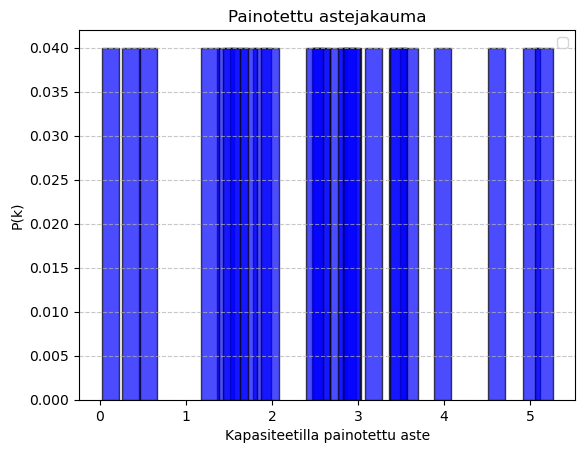

In [35]:
# Count occurrences of each degree
weighted_degree_counts = Counter(weighted_degrees)

# Total number of nodes
weighted_total_nodes = len(weighted_degrees)

# Calculate probabilities
weighted_degree_values = list(weighted_degree_counts.keys())
weighted_probabilities = [count / weighted_total_nodes for count in weighted_degree_counts.values()]


# Plot the degree distribution with probabilities

plt.bar(weighted_degree_values, weighted_probabilities, width=0.2, color='blue', edgecolor='black', alpha=0.7)
plt.rcParams['axes.facecolor'] = 'white'
plt.legend()
plt.xlabel("Kapasiteetilla painotettu aste")
plt.ylabel("P(k)")
plt.title("Painotettu astejakauma")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

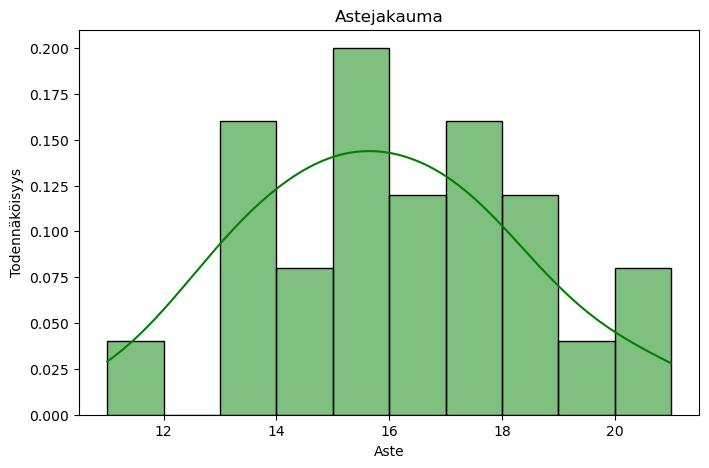

In [36]:
plt.figure(figsize=(8, 5))
sns.histplot(degrees, bins=10, stat='probability', kde=True, color='green')
plt.title("Astejakauma")
plt.xlabel("Aste")
plt.ylabel("Todennäköisyys")
plt.show()

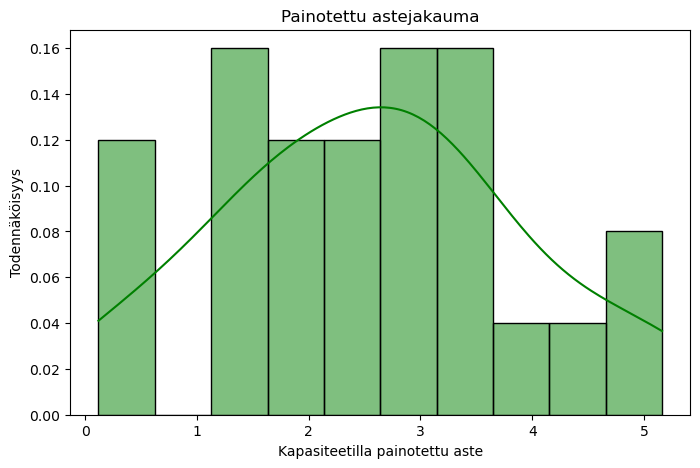

In [37]:
plt.figure(figsize=(8, 5))
sns.histplot(weighted_degrees, stat='probability', bins=10, kde=True, color='green')
plt.title("Painotettu astejakauma")
plt.xlabel("Kapasiteetilla painotettu aste")
plt.ylabel("Todennäköisyys")
plt.show()

# verkon plottaus:

In [38]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

c:\Users\35844\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


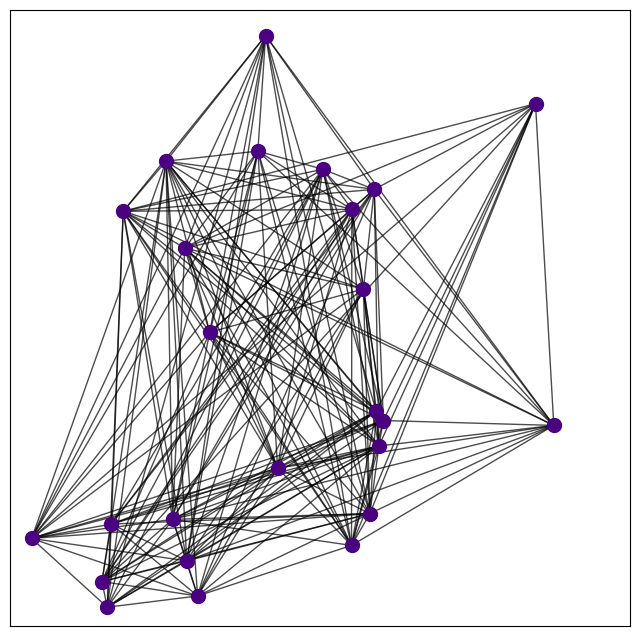

In [54]:

pos = nx.get_node_attributes(testi.G, "pos")

plt.figure(figsize=(8, 8))
plt.rcParams['axes.facecolor'] = 'white'
nx.draw_networkx_edges(
    testi.G, 
    pos,
    edgelist= testi.G.edges, 
    width= 1,
    alpha=0.7,
    
)

nx.draw_networkx_nodes(
    testi.G,
    pos,
    nodelist=testi.G.nodes,
    node_size=100,
    node_color='indigo',
    cmap=plt.cm.Reds_r,
)

plt.xlim(-5, 205)
plt.ylim(-5, 205)
plt.axis()
plt.show()

In [40]:
from matplotlib import colormaps
import matplotlib as mpl

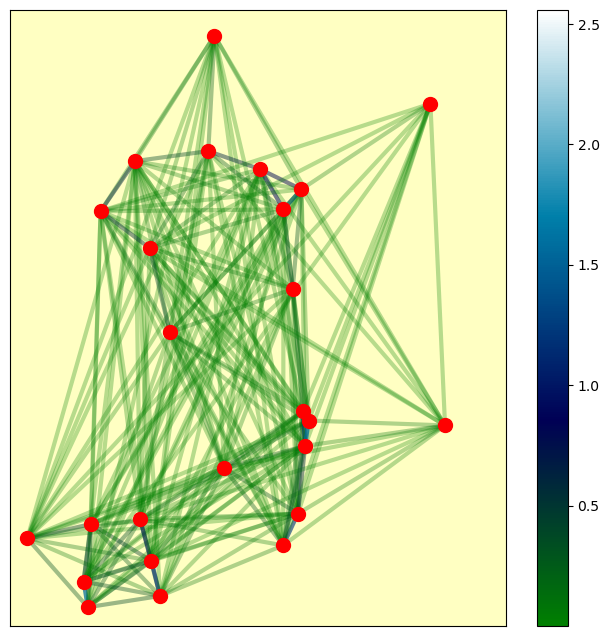

In [41]:

pos = nx.get_node_attributes(testi.G, "pos")


#colors = range(len(testi.G.edges))

capacities = nx.get_edge_attributes(testi.G, 'capacity').values()
norm = mcolors.Normalize(vmin=min(capacities), vmax=max(capacities))
cmap = cm.ocean # Choose a colormap
edge_colors = [cmap(norm(cap)) for cap in capacities]

alphas = [(1+cap)/(1+max(capacities)) for cap in capacities]

fig = plt.figure(figsize=(8, 8))

ax = plt.gca()
ax.set_facecolor('xkcd:cream')

nx.draw_networkx_edges(
    testi.G, 
    pos,
    edgelist= testi.G.edges, 
    width= 3,
    edge_color= edge_colors,
    alpha=alphas,
    
)

nx.draw_networkx_nodes(
    testi.G,
    pos,
    nodelist=testi.G.nodes,
    node_size=100,
    node_color='red',
    cmap=plt.cm.Reds_r,
)

#pc = mpl.collections.PatchCollection(, cmap=cmap)
#pc.set_array(edge_colors)

plt.xlim(-5, 205)
plt.ylim(-5, 205)
plt.axis()
fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
plt.show()


plottaa uudelleen siten, että noodien väri määräytyy kapasiteetista?

# kapasiteettijakauma:

kapas_jak = []

for i in range(25):
    for j in range(i+1, 25):
        if testi.capacity_matrix[i][j] > 0.0:
            kapas_jak.append(testi.capacity_matrix[i][j])


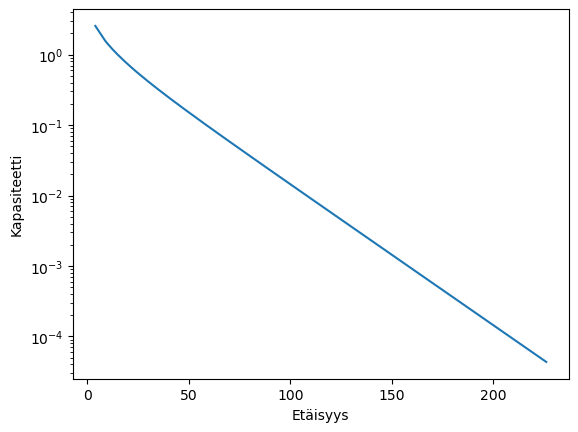

In [42]:
plt.figure()
y = []
for i in range(Ö):
            for j in range(Ö):
                if testi.adjacency_matrix[i][j] == 1:
                    y.append(testi.distance_matrix[i][j])

cap = []
for i in y:
      cap.append(- math.log2(1 - 10**(-testi.gamma*i*0.1)))
y.sort()
cap.sort(reverse=True)

plt.semilogy()
plt.plot(y, cap)
plt.xlabel("Etäisyys")
plt.ylabel("Kapasiteetti")

plt.show()

# Minimileikkauksen ja kapasiteetilla painotettujen asteiden minimin plottaus


-miten hyvin asteiden minimi ennustaa minimileikkausta?

In [43]:
min_degree_weighted #kapasiteetilla painotetut asteet
min_cuts # minimileikkaukset noodien välillä

[[0,
  0.5576471377953012,
  1.7711248817801777,
  1.799225543670136,
  1.7711248817801772,
  2.574241094385031,
  1.7992255436701363,
  1.7711248817801777,
  2.5742410943850316,
  2.574241094385031,
  2.5742410943850307,
  1.7992255436701359,
  0.11912997352470042,
  0.35937150866293655,
  1.4567046706282287,
  1.7711248817801772,
  1.799225543670136,
  2.574241094385031,
  1.7992255436701368,
  1.723829605318371,
  1.27748177772241,
  1.7711248817801777,
  1.6159912472719882,
  1.5318905073897509,
  1.7992255436701359],
 [0.5576471377953012,
  0,
  0.5576471377953011,
  0.5576471377953013,
  0.5576471377953011,
  0.5576471377953012,
  0.5576471377953013,
  0.5576471377953011,
  0.5576471377953012,
  0.5576471377953011,
  0.5576471377953011,
  0.5576471377953013,
  0.11912997352470042,
  0.3593715086629366,
  0.5576471377953012,
  0.5576471377953013,
  0.5576471377953012,
  0.5576471377953012,
  0.557647137795301,
  0.5576471377953011,
  0.5576471377953011,
  0.5576471377953013,
  0.5

In [44]:
#kap_ast = [sum(element for element in row if element is not None) for row in min_degree_weighted]
#min_leik = [sum(element for element in row if element is not None) for row in min_cuts]
kap_ast = []
min_leik = []

for i in range(Ö):
    for j in range(i+1,Ö):
        if min_degree_weighted[i][j] != 0:
            kap_ast.append(min_degree_weighted[i][j])

for i in range(Ö):
    for j in range(i+1,Ö):
        if min_cuts[i][j] != 0:
            min_leik.append(min_cuts[i][j])

kap_ast.sort()
min_leik.sort()

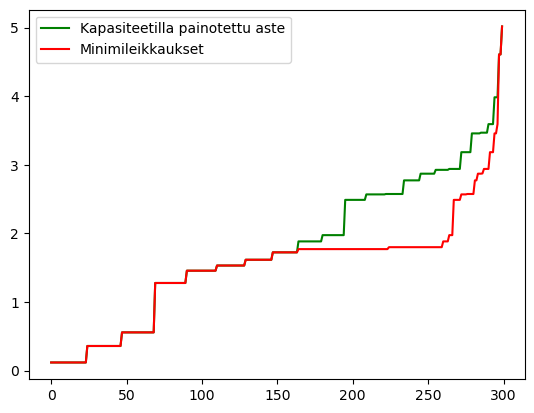

In [45]:
plt.figure()
plt.plot(kap_ast, label= "Kapasiteetilla painotettu aste", color = 'green')
plt.plot(min_leik, label="Minimileikkaukset", color='red')

plt.legend()
plt.show()

## -millaisissa tilanteissa nämä ovat lähellä toisiaan? millaisissa tilanteissa kaukana?

mitä kauempana noodit ovt toisistaa, sitä lähempänä mincut ja kapaste ovat toisiaan(ei?) lähellä ja kaukana lähellätoisiaan? mutta välissä ei?

## -miten verkon noodien lukumäärä vaikuttaa? miten laatikon koko vaikuttaa?

Mitä enemmän noodeja, sitä lähempänä toisiaan? Laatikon koko vaikuttaa siten, että pienemmällä laatikolla lähempänä toisiaan?

### -miten Waxman-verkkojen rakenne selittää em havainnot?
(kapasiteetti ja linkin todennäköisys molemmat etäisyydestä riippuvia, mikä selittää että tulokset lähellä toisiaan?)(erityisesti kun etäisyydet pieniä)

# todennäköisyysjakauma:

In [46]:
tod_jakauma = []

for i in range(Ö):
    for j in range(i+1, Ö):
        tod_jakauma.append(testi.propability_matrix[i][j])



In [47]:
print(tod_jakauma)

[0.46195623162396465, 0.5466575973412982, 0.7686209279285476, 0.5368528253167587, 0.8820117967261905, 0.6785341067989961, 0.5955861881756336, 0.9159061168275435, 0.9119561626416609, 0.8816742133410312, 0.6491788386732655, 0.4074233792396787, 0.5068019303624931, 0.5748922023978424, 0.5270641167859026, 0.6462382510470007, 0.8447071750143199, 0.6967009498226244, 0.6501851228953142, 0.8856645612551847, 0.5509749219497031, 0.6236344618405778, 0.7228119302329146, 0.6583727977119133, 0.8397495505515618, 0.5206482651377946, 0.8031803057212589, 0.40888576869956966, 0.47816262465294346, 0.6641129471839526, 0.423450093795508, 0.47570555159983297, 0.44881531322705004, 0.5542747077369823, 0.6587870528150672, 0.4820969271972828, 0.7857603034245548, 0.7532079929349879, 0.5450522056699406, 0.4268017210447938, 0.45851919101026345, 0.7097819779653995, 0.4335951272590201, 0.7465736724901151, 0.7115928437319333, 0.6341670984900899, 0.5263276839334761, 0.6193492356860713, 0.9037357267177349, 0.484777708704

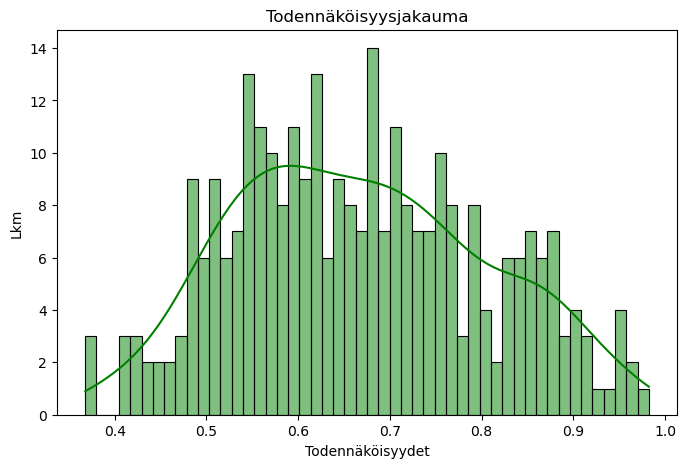

In [48]:
plt.figure(figsize=(8, 5))
sns.histplot(tod_jakauma, stat='count', bins=50, kde=True, color='green')
plt.title("Todennäköisyysjakauma")
plt.xlabel("Todennäköisyydet")
plt.ylabel("Lkm")
plt.show()



# etäisyysjakauma:

In [49]:
et_jak = []

for i in range(Ö):
    for j in range(i+1, Ö):
        et_jak.append(testi.distance_matrix[i][j])

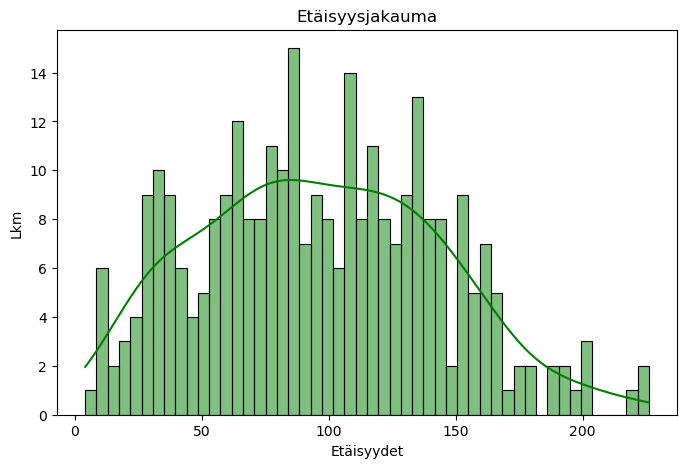

In [50]:
plt.figure(figsize=(8, 5))
sns.histplot(et_jak, stat='count', bins=50, kde=True, color='green')
plt.title("Etäisyysjakauma")
plt.xlabel("Etäisyydet")
plt.ylabel("Lkm")
plt.show()

Palkit kuvaavat todellisia kertymiä ja kuvaaja on niihin sovitettu approksimaatio (myös ylempänä todennäköisyysjakauman kuvaajassa ja muissa)

# min. leikkaus kahdelle vapaavalintaiselle noodille:

Nyt olisi tarkoitus alkaa laskea minimileikkauksia kapasiteetilla painotetuille verkoille. Sen pitäisi onnistua käyttämällä NetworkX pakettia. Minimileikkaus kahden noodin välillähän tarkoittaa suurinta mahdollista kapasiteettia siirtää tietoa noodista toiseen. Nyt tarkastelun kohteena olevissa Waxman-verkoissa on syytä uskoa että tämä kapasiteetti on lähellä noodien kapasiteetilla painotettua astetta. Tämä johtuu siitä että näissä verkoissa sekä noodien asteilla että linkkien pituuksilla (ja sitä kautta kapasiteeteilla) on taipumus olla lähellä toisiaan.

Voit esimerkiksi tehdä uudet matriisit joista toisessa elementti i,j on noodien i,j minimileikkaus ja toisessa min(d_C(i),d_C(j)) missä d_C on noodin kapasiteetilla painotettu aste ja tarkastella seuraavia asioita
-miten hyvin asteiden minimi ennustaa minimileikkausta?
-millaisissa tilanteissa nämä ovat lähellä toisiaan? millaisissa tilanteissa kaukana?
-miten verkon noodien lukumäärä vaikuttaa? miten laatikon koko vaikuttaa?
-miten Waxman-verkkojen rakenne selittää em havainnot?

Lisäksi voisi tehdä verkoista kuvia missä linkkien esim väri on valittu kapasiteetin mukaan.


# min. leikkausjakauma:

In [51]:
# hyödynnä tehtyjä matriiseja minleikkauksen ja min kapasiteetilla painotetun 
# asteen plottaukseen




In [52]:
min_leik_jak = []

for i in range(Ö):
    for j in range(i+1, Ö):
        min_leik_jak.append(testi.min_cut_matrix[i][j])

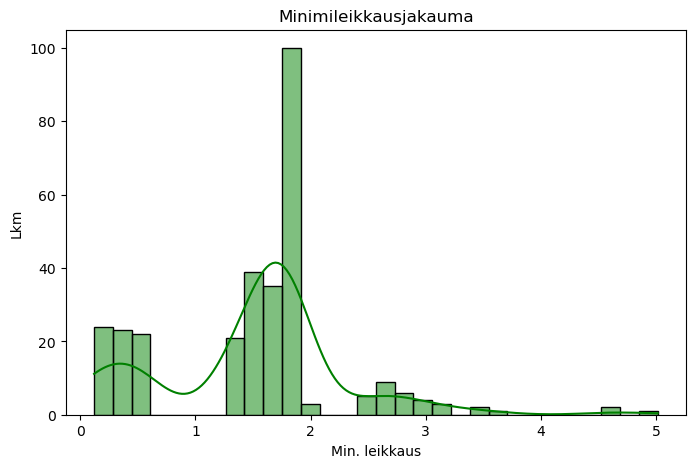

In [53]:
plt.figure(figsize=(8, 5))
sns.histplot(min_leik, stat='count', bins=30, kde=True, color='green')
plt.title("Minimileikkausjakauma")
plt.xlabel("Min. leikkaus")
plt.ylabel("Lkm")
plt.show()